In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ortools_solver import CVRP_solver
from utils import random_choose_candidate, distance_calculator, calculate_distance_matrix, show_matrix, get_optimized_sequence, print_command
from QAP_solver import calculate_T, CVRP_QAP
import pygmtools as pygm

/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
D = np.ones((96,96))
for i in range(96):
    for j in range(96):
        if i//8 == j//8:
            if i-j == -1:
                D[i,j] = 0

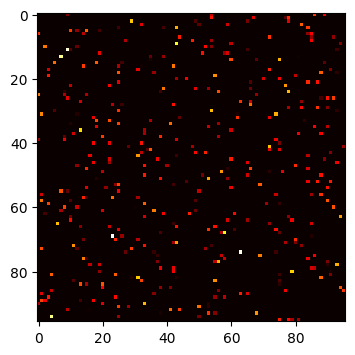

In [2]:
# generate the random addition matrix
# row is the source, column is the destination
a= np.eye(96)
a = random_choose_candidate(96,96,4)
show_matrix(a)
# randomly shuffle the rows
#np.random.shuffle(a)
# binarize the matrix as 0 and 1
a[a>0] = 1

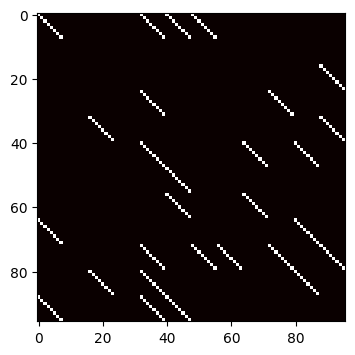

In [3]:
# generate the non-symmetric matrix
# devide a 96*96 matrix into 12*12 8*8 matrix
# randomly choose n matrix to add a diagonal matrix
a = np.zeros((96,96))
# randomly pick n number from 0 to 144
picked_submatrix = np.random.choice(144, 28, replace=False)
n = 0
for i in range(12):
    for j in range(12):
        if n in picked_submatrix:
            a[i*8:(i+1)*8, j*8:(j+1)*8] = np.eye(8)
        n += 1
show_matrix(a)

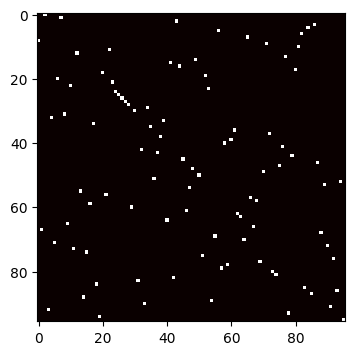

In [6]:
column_permutation = np.eye(96)
# Function to swap two columns in a matrix
def swap_columns(matrix, col1, col2):
    matrix[:, [col1, col2]] = matrix[:, [col2, col1]]

# pick an integer from 0 to 10 with gaussian distribution
for i in range(20):
    num_permutation = np.random.normal(5, 2)
    num_permutation = int(num_permutation)
    # randomly swipe two columns n times
    for j in range(num_permutation):
        exchange_columns = np.random.choice(96, 2, replace=False)
        swap_columns(column_permutation, exchange_columns[0], exchange_columns[1])
show_matrix(column_permutation)

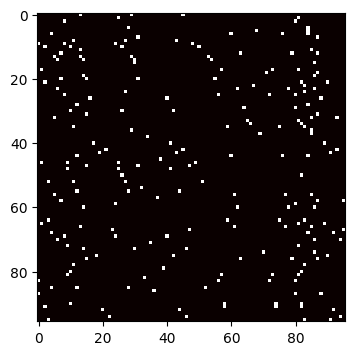

In [14]:
a = np.dot(column_permutation, a)
show_matrix(a)

In [15]:
# generate the job pair
jobs = np.argwhere(a)
volume = [a[i,j] for i,j in jobs]
volume = np.array(volume)
#distance_matrix = calculate_distance_matrix(jobs)
#S,E = calculate_S_E(jobs)
#D_prime = calculate_D_prime(D, S, E)

In [16]:
test_cost, test_P = CVRP_QAP(jobs,iteration=20)

Objective: 220
iter=0, cost=220.0 after CVRP
iter=0, cost=216.0 after QAP
Objective: 205
iter=1, cost=205.0 after CVRP
iter=1, cost=205.0 after QAP
Objective: 207
iter=2, cost=207.0 after CVRP
iter=2, cost=207.0 after QAP
Objective: 205
iter=3, cost=205.0 after CVRP
iter=3, cost=205.0 after QAP
Objective: 207
iter=4, cost=207.0 after CVRP
iter=4, cost=207.0 after QAP
Objective: 207
iter=5, cost=207.0 after CVRP
iter=5, cost=207.0 after QAP
Objective: 200
iter=6, cost=200.0 after CVRP
iter=6, cost=200.0 after QAP
Objective: 194
iter=7, cost=194.0 after CVRP
iter=7, cost=194.0 after QAP
Objective: 194
iter=8, cost=194.0 after CVRP
iter=8, cost=194.0 after QAP
Objective: 194
iter=9, cost=194.0 after CVRP
iter=9, cost=194.0 after QAP
Objective: 194
iter=10, cost=194.0 after CVRP
iter=10, cost=194.0 after QAP
Objective: 194
iter=11, cost=194.0 after CVRP
iter=11, cost=194.0 after QAP
Objective: 194
iter=12, cost=194.0 after CVRP
iter=12, cost=194.0 after QAP
Objective: 194
iter=13, cost=194

In [18]:
update_a = np.dot(a,test_P)
jobs = np.argwhere(update_a)
distance_matrix = calculate_distance_matrix(jobs)
VRP_distance, VRP_recorder = CVRP_solver(distance_matrix)
recorder = get_optimized_sequence(VRP_recorder)

Objective: 199


In [7]:
sequence = recorder.flatten()
sequence = sequence[sequence!=-1] -1
command_line = print_command(sequence,jobs)
np.savetxt('optimized_command_line.csv',command_line,fmt='%s',delimiter=',')

In [8]:
jobs = np.argwhere(a)
unoptimized_command_line = print_command(np.array(range(jobs.shape[0])),jobs)
np.savetxt('unoptimized_command_line.csv',unoptimized_command_line,fmt='%s',delimiter=',')

In [4]:
stat = []
for i in range(1,20):
    experiments = random_choose_candidate(96,96,i)
    jobs = np.argwhere(experiments)
    distance_matrix = calculate_distance_matrix(jobs)
    optimized_distance,recorder = CVRP_QAP(jobs,iteration=20)
    VRP_distance, _ = CVRP_solver(distance_matrix)
    non_optimized_distance = distance_calculator(jobs)
    stat.append((i,non_optimized_distance,optimized_distance, VRP_distance))
stat = np.array(stat)

Objective: 89
iter=0, cost=89.0 after CVRP
iter=0, cost=53.0 after QAP
Objective: 56
iter=1, cost=56.0 after CVRP
iter=1, cost=54.0 after QAP
Objective: 53
iter=2, cost=53.0 after CVRP


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: divide by zero encountered in divide
  t0 = - alpha / beta
/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:309: RuntimeWarning: invalid value encountered in multiply
  v = np.where(np.logical_or(beta >= 0, t0 >= 1), binary_v, v + t0 * (binary_v - v))
/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: invalid value encountered in divide
  t0 = - alpha / beta


iter=2, cost=52.0 after QAP
Objective: 49
iter=3, cost=49.0 after CVRP
iter=3, cost=49.0 after QAP
Objective: 49
iter=4, cost=49.0 after CVRP
iter=4, cost=49.0 after QAP
Objective: 49
iter=5, cost=49.0 after CVRP
iter=5, cost=49.0 after QAP
Objective: 49
iter=6, cost=49.0 after CVRP
iter=6, cost=49.0 after QAP
Objective: 49
iter=7, cost=49.0 after CVRP
iter=7, cost=49.0 after QAP
Objective: 49
iter=8, cost=49.0 after CVRP
iter=8, cost=49.0 after QAP
Objective: 49
iter=9, cost=49.0 after CVRP
iter=9, cost=49.0 after QAP
Objective: 49
iter=10, cost=49.0 after CVRP
iter=10, cost=49.0 after QAP
Objective: 49
iter=11, cost=49.0 after CVRP
iter=11, cost=49.0 after QAP
Objective: 49
iter=12, cost=49.0 after CVRP
iter=12, cost=49.0 after QAP
Objective: 49
iter=13, cost=49.0 after CVRP
iter=13, cost=49.0 after QAP
Objective: 49
iter=14, cost=49.0 after CVRP
iter=14, cost=49.0 after QAP
Objective: 49
iter=15, cost=49.0 after CVRP
iter=15, cost=49.0 after QAP
Objective: 49
iter=16, cost=49.0 afte

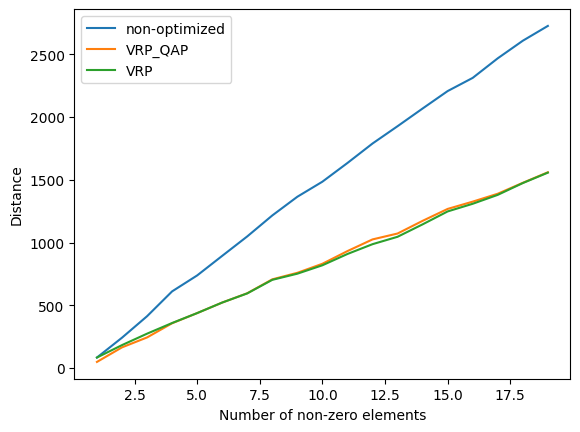

In [5]:
# plot the result
plt.plot(stat[:,0],stat[:,1],label='non-optimized')
plt.plot(stat[:,0],stat[:,2],label='VRP_QAP')
plt.plot(stat[:,0],stat[:,3],label='VRP')
plt.legend()
plt.xlabel('Number of non-zero elements')
plt.ylabel('Distance')
plt.show()

In [7]:
def matrix_to_sequence(matrix,optimization_iteration=5):
    jobs = np.argwhere(matrix)
    distance_matrix = calculate_distance_matrix(jobs)
    optimized_distance,P = CVRP_QAP(jobs,iteration=optimization_iteration)
    updated_matrix = np.dot(matrix,P)
    updated_jobs = np.argwhere(updated_matrix)
    distance_matrix = calculate_distance_matrix(updated_jobs)
    optimized_distance, _ = CVRP_solver(distance_matrix)
    non_optimized_distance = distance_calculator(jobs)
    return non_optimized_distance, optimized_distance

Objective: 26
iter=0, cost=26.0 after CVRP


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: invalid value encountered in divide
  t0 = - alpha / beta


iter=0, cost=26.0 after QAP
Objective: 26
iter=1, cost=26.0 after CVRP
iter=1, cost=26.0 after QAP
Objective: 26
iter=2, cost=26.0 after CVRP
iter=2, cost=26.0 after QAP
Objective: 26
iter=3, cost=26.0 after CVRP
iter=3, cost=26.0 after QAP
Objective: 26
iter=4, cost=26.0 after CVRP
iter=4, cost=26.0 after QAP
Objective: 0


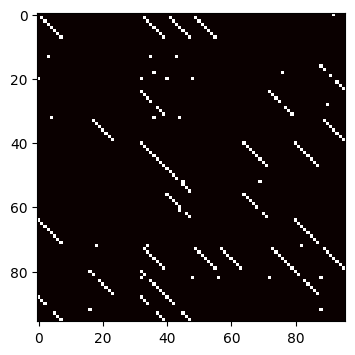

Objective: 82
iter=0, cost=82.0 after CVRP
iter=0, cost=82.0 after QAP
Objective: 82
iter=1, cost=82.0 after CVRP
iter=1, cost=82.0 after QAP
Objective: 82
iter=2, cost=82.0 after CVRP
iter=2, cost=82.0 after QAP
Objective: 82
iter=3, cost=82.0 after CVRP
iter=3, cost=82.0 after QAP
Objective: 82
iter=4, cost=82.0 after CVRP
iter=4, cost=82.0 after QAP
Objective: 66


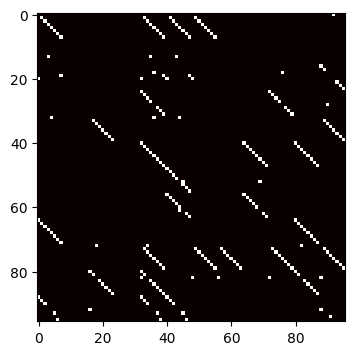

Objective: 92
iter=0, cost=92.0 after CVRP
iter=0, cost=92.0 after QAP
Objective: 92
iter=1, cost=92.0 after CVRP
iter=1, cost=92.0 after QAP
Objective: 92
iter=2, cost=92.0 after CVRP
iter=2, cost=92.0 after QAP
Objective: 92
iter=3, cost=92.0 after CVRP
iter=3, cost=92.0 after QAP
Objective: 92
iter=4, cost=92.0 after CVRP
iter=4, cost=92.0 after QAP
Objective: 85


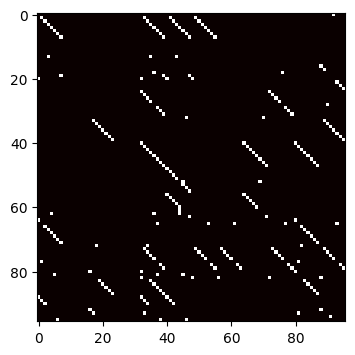

Objective: 91
iter=0, cost=91.0 after CVRP
iter=0, cost=91.0 after QAP
Objective: 91
iter=1, cost=91.0 after CVRP
iter=1, cost=91.0 after QAP
Objective: 91
iter=2, cost=91.0 after CVRP
iter=2, cost=91.0 after QAP
Objective: 91
iter=3, cost=91.0 after CVRP
iter=3, cost=91.0 after QAP
Objective: 91
iter=4, cost=91.0 after CVRP
iter=4, cost=91.0 after QAP
Objective: 90


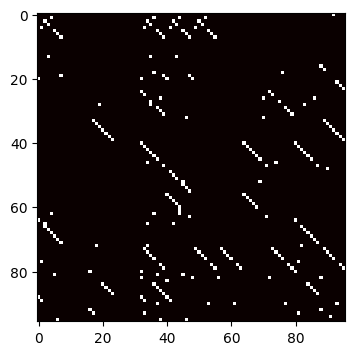

Objective: 128
iter=0, cost=128.0 after CVRP
iter=0, cost=128.0 after QAP
Objective: 128
iter=1, cost=128.0 after CVRP
iter=1, cost=128.0 after QAP
Objective: 128
iter=2, cost=128.0 after CVRP
iter=2, cost=128.0 after QAP
Objective: 128
iter=3, cost=128.0 after CVRP
iter=3, cost=128.0 after QAP
Objective: 128
iter=4, cost=128.0 after CVRP
iter=4, cost=128.0 after QAP
Objective: 120


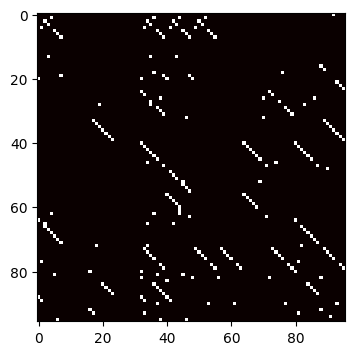

Objective: 128
iter=0, cost=128.0 after CVRP
iter=0, cost=128.0 after QAP
Objective: 128
iter=1, cost=128.0 after CVRP
iter=1, cost=128.0 after QAP
Objective: 128
iter=2, cost=128.0 after CVRP
iter=2, cost=128.0 after QAP
Objective: 128
iter=3, cost=128.0 after CVRP
iter=3, cost=128.0 after QAP
Objective: 128
iter=4, cost=128.0 after CVRP
iter=4, cost=128.0 after QAP
Objective: 119


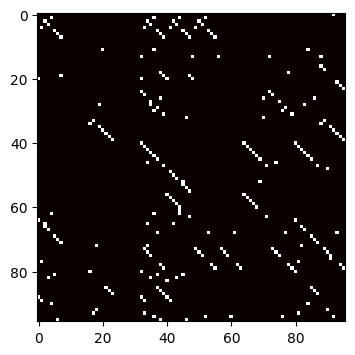

Objective: 152
iter=0, cost=152.0 after CVRP
iter=0, cost=152.0 after QAP
Objective: 159
iter=1, cost=159.0 after CVRP
iter=1, cost=159.0 after QAP
Objective: 159
iter=2, cost=159.0 after CVRP
iter=2, cost=159.0 after QAP
Objective: 159
iter=3, cost=159.0 after CVRP
iter=3, cost=159.0 after QAP
Objective: 159
iter=4, cost=159.0 after CVRP
iter=4, cost=159.0 after QAP
Objective: 148


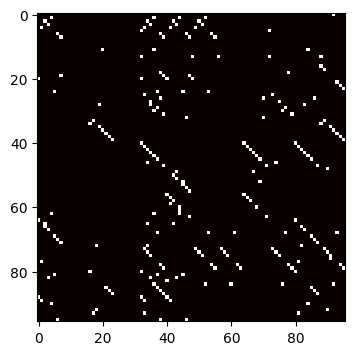

Objective: 159
iter=0, cost=159.0 after CVRP
iter=0, cost=159.0 after QAP
Objective: 159
iter=1, cost=159.0 after CVRP
iter=1, cost=159.0 after QAP
Objective: 159
iter=2, cost=159.0 after CVRP
iter=2, cost=159.0 after QAP
Objective: 159
iter=3, cost=159.0 after CVRP
iter=3, cost=159.0 after QAP
Objective: 159
iter=4, cost=159.0 after CVRP
iter=4, cost=159.0 after QAP
Objective: 153


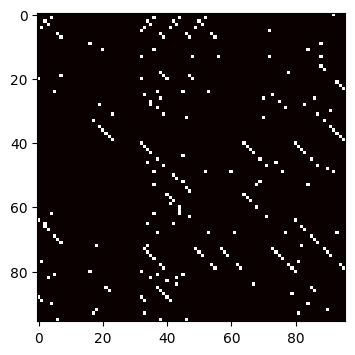

Objective: 175
iter=0, cost=175.0 after CVRP
iter=0, cost=175.0 after QAP
Objective: 176
iter=1, cost=176.0 after CVRP
iter=1, cost=177.0 after QAP
Objective: 177
iter=2, cost=177.0 after CVRP
iter=2, cost=177.0 after QAP
Objective: 177
iter=3, cost=177.0 after CVRP
iter=3, cost=177.0 after QAP
Objective: 177
iter=4, cost=177.0 after CVRP
iter=4, cost=177.0 after QAP
Objective: 171


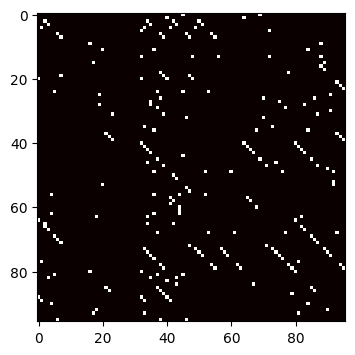

Objective: 176
iter=0, cost=176.0 after CVRP
iter=0, cost=176.0 after QAP
Objective: 162
iter=1, cost=162.0 after CVRP
iter=1, cost=162.0 after QAP
Objective: 162
iter=2, cost=162.0 after CVRP
iter=2, cost=162.0 after QAP
Objective: 162
iter=3, cost=162.0 after CVRP
iter=3, cost=162.0 after QAP
Objective: 162
iter=4, cost=162.0 after CVRP
iter=4, cost=162.0 after QAP
Objective: 162


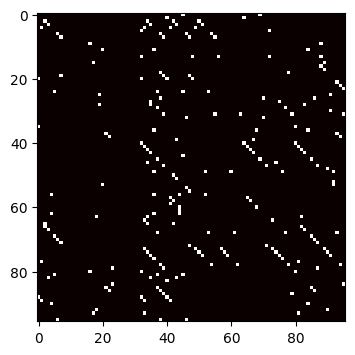

Objective: 177
iter=0, cost=177.0 after CVRP
iter=0, cost=177.0 after QAP
Objective: 176
iter=1, cost=176.0 after CVRP
iter=1, cost=176.0 after QAP
Objective: 176
iter=2, cost=176.0 after CVRP
iter=2, cost=176.0 after QAP
Objective: 176
iter=3, cost=176.0 after CVRP
iter=3, cost=176.0 after QAP
Objective: 176
iter=4, cost=176.0 after CVRP
iter=4, cost=176.0 after QAP
Objective: 174


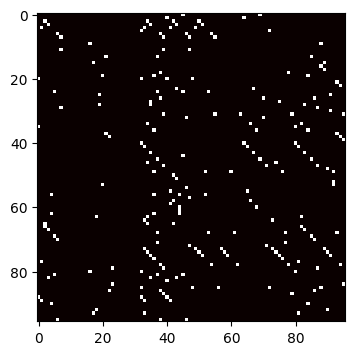

Objective: 181
iter=0, cost=181.0 after CVRP
iter=0, cost=181.0 after QAP
Objective: 181
iter=1, cost=181.0 after CVRP
iter=1, cost=181.0 after QAP
Objective: 181
iter=2, cost=181.0 after CVRP
iter=2, cost=181.0 after QAP
Objective: 181
iter=3, cost=181.0 after CVRP
iter=3, cost=181.0 after QAP
Objective: 181
iter=4, cost=181.0 after CVRP
iter=4, cost=181.0 after QAP
Objective: 178


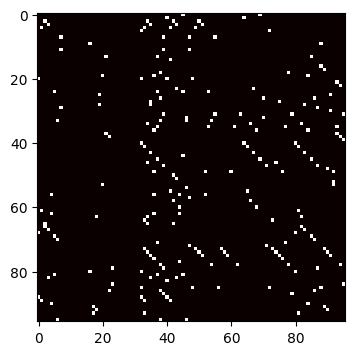

Objective: 188
iter=0, cost=188.0 after CVRP
iter=0, cost=188.0 after QAP
Objective: 188
iter=1, cost=188.0 after CVRP
iter=1, cost=188.0 after QAP
Objective: 188
iter=2, cost=188.0 after CVRP
iter=2, cost=188.0 after QAP
Objective: 188
iter=3, cost=188.0 after CVRP
iter=3, cost=188.0 after QAP
Objective: 188
iter=4, cost=188.0 after CVRP
iter=4, cost=188.0 after QAP
Objective: 188


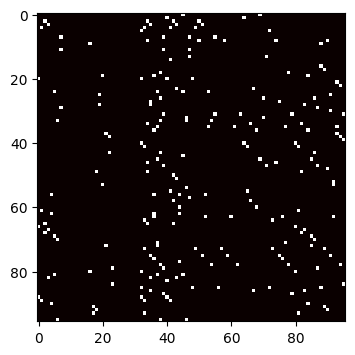

Objective: 198
iter=0, cost=198.0 after CVRP
iter=0, cost=198.0 after QAP
Objective: 202
iter=1, cost=202.0 after CVRP
iter=1, cost=202.0 after QAP
Objective: 202
iter=2, cost=202.0 after CVRP
iter=2, cost=202.0 after QAP
Objective: 202
iter=3, cost=202.0 after CVRP
iter=3, cost=202.0 after QAP
Objective: 202
iter=4, cost=202.0 after CVRP
iter=4, cost=202.0 after QAP
Objective: 198


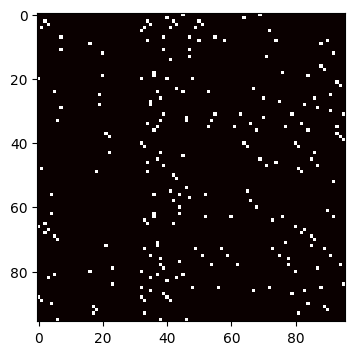

Objective: 199
iter=0, cost=199.0 after CVRP


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: divide by zero encountered in divide
  t0 = - alpha / beta
/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:309: RuntimeWarning: invalid value encountered in multiply
  v = np.where(np.logical_or(beta >= 0, t0 >= 1), binary_v, v + t0 * (binary_v - v))


iter=0, cost=198.0 after QAP
Objective: 197
iter=1, cost=197.0 after CVRP
iter=1, cost=197.0 after QAP
Objective: 196
iter=2, cost=196.0 after CVRP
iter=2, cost=196.0 after QAP
Objective: 196
iter=3, cost=196.0 after CVRP
iter=3, cost=196.0 after QAP
Objective: 196
iter=4, cost=196.0 after CVRP
iter=4, cost=196.0 after QAP
Objective: 195


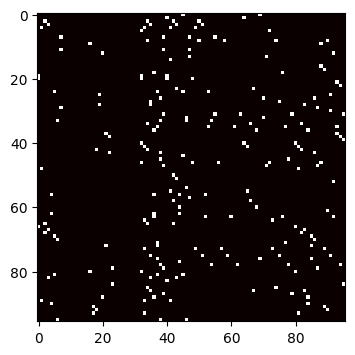

Objective: 208
iter=0, cost=208.0 after CVRP
iter=0, cost=208.0 after QAP
Objective: 206
iter=1, cost=206.0 after CVRP
iter=1, cost=206.0 after QAP
Objective: 206
iter=2, cost=206.0 after CVRP
iter=2, cost=206.0 after QAP
Objective: 206
iter=3, cost=206.0 after CVRP
iter=3, cost=206.0 after QAP
Objective: 206
iter=4, cost=206.0 after CVRP
iter=4, cost=206.0 after QAP
Objective: 198


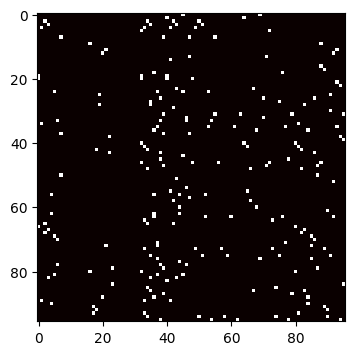

Objective: 208
iter=0, cost=208.0 after CVRP
iter=0, cost=208.0 after QAP
Objective: 202
iter=1, cost=202.0 after CVRP
iter=1, cost=202.0 after QAP
Objective: 202
iter=2, cost=202.0 after CVRP
iter=2, cost=202.0 after QAP
Objective: 203
iter=3, cost=203.0 after CVRP
iter=3, cost=203.0 after QAP
Objective: 202
iter=4, cost=202.0 after CVRP
iter=4, cost=202.0 after QAP
Objective: 205


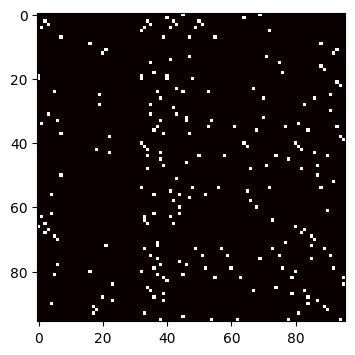

Objective: 206
iter=0, cost=206.0 after CVRP
iter=0, cost=206.0 after QAP
Objective: 203
iter=1, cost=203.0 after CVRP
iter=1, cost=203.0 after QAP
Objective: 201
iter=2, cost=201.0 after CVRP
iter=2, cost=201.0 after QAP
Objective: 204
iter=3, cost=204.0 after CVRP
iter=3, cost=204.0 after QAP
Objective: 204
iter=4, cost=204.0 after CVRP
iter=4, cost=204.0 after QAP
Objective: 205


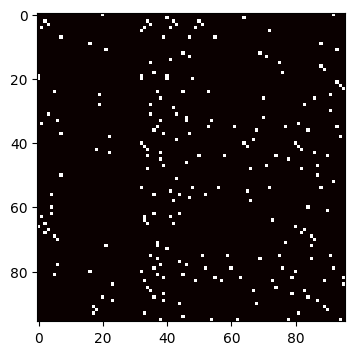

Objective: 210
iter=0, cost=210.0 after CVRP
iter=0, cost=210.0 after QAP
Objective: 203
iter=1, cost=203.0 after CVRP
iter=1, cost=201.0 after QAP
Objective: 201
iter=2, cost=201.0 after CVRP
iter=2, cost=201.0 after QAP
Objective: 207
iter=3, cost=207.0 after CVRP
iter=3, cost=208.0 after QAP
Objective: 204
iter=4, cost=204.0 after CVRP
iter=4, cost=204.0 after QAP
Objective: 206


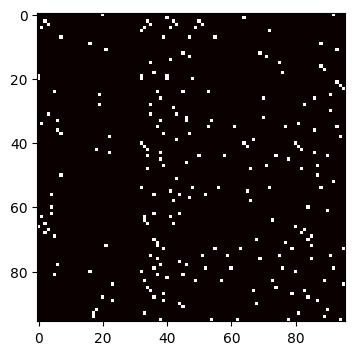

Objective: 207
iter=0, cost=207.0 after CVRP
iter=0, cost=206.0 after QAP
Objective: 208
iter=1, cost=208.0 after CVRP
iter=1, cost=208.0 after QAP
Objective: 208
iter=2, cost=208.0 after CVRP
iter=2, cost=208.0 after QAP
Objective: 208
iter=3, cost=208.0 after CVRP
iter=3, cost=208.0 after QAP
Objective: 208
iter=4, cost=208.0 after CVRP
iter=4, cost=208.0 after QAP
Objective: 206


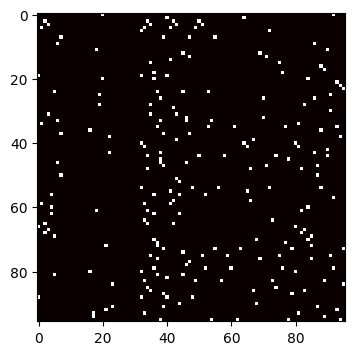

Objective: 206
iter=0, cost=206.0 after CVRP
iter=0, cost=206.0 after QAP
Objective: 208
iter=1, cost=208.0 after CVRP
iter=1, cost=208.0 after QAP
Objective: 208
iter=2, cost=208.0 after CVRP
iter=2, cost=208.0 after QAP
Objective: 208
iter=3, cost=208.0 after CVRP
iter=3, cost=208.0 after QAP
Objective: 208
iter=4, cost=208.0 after CVRP
iter=4, cost=208.0 after QAP
Objective: 202


In [9]:
column_permutation = np.eye(96)
# Function to swap two columns in a matrix
def swap_columns(matrix, col1, col2):
    matrix[:, [col1, col2]] = matrix[:, [col2, col1]]
# record the optimized distance and non-optimized distance in each permutation
update_a = a
stat = []
optimized_distance, non_optimized_distance = matrix_to_sequence(update_a)
stat.append((0,non_optimized_distance,optimized_distance))
# pick an integer from 0 to 10 with gaussian distribution
for i in range(20):
    num_permutation = np.random.normal(5, 2)
    num_permutation = int(num_permutation)
    # randomly swipe two columns n times
    for j in range(num_permutation):
        exchange_columns = np.random.choice(96, 2, replace=False)
        swap_columns(column_permutation, exchange_columns[0], exchange_columns[1])
    update_a = np.dot(column_permutation, a)
    show_matrix(update_a)
    optimized_distance, non_optimized_distance = matrix_to_sequence(update_a)
    stat.append((i+1,non_optimized_distance,optimized_distance))
stat = np.array(stat)

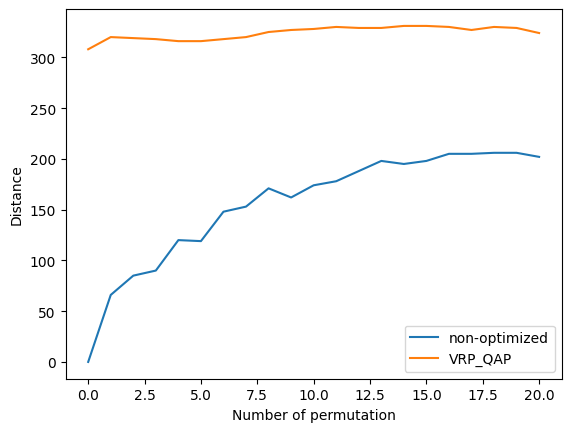

In [11]:
# plot the result
plt.plot(stat[:,0],stat[:,1],label='non-optimized')
plt.plot(stat[:,0],stat[:,2],label='VRP_QAP')
plt.legend()
plt.xlabel('Number of permutation')
plt.ylabel('Distance')
plt.show()
